# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate, LeakyReLU, Reshape, Conv2DTranspose, Flatten, Conv2D
from tensorflow.keras.models import Model,Sequential

from utils import *

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices()
print("All available physical devices:", physical_devices)

# Select a GPU device for training
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    device = gpu_devices[0]
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, 'GPU')
    print("Selected GPU device:", device)
else:
    print("No GPU devices found.")
    

All available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Selected GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load training and test data

In [3]:
outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")
# outerdata_train = np.load("./data/preprocessed_data_6var_more_training_data/outerdata_train_6var.npy")
# outerdata_test = np.load("./data/preprocessed_data_6var_more_training_data/outerdata_test_6var.npy")

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)

print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
print('shape of cond_data: ', cond_data.shape)

shape of data_train:  (499889, 6)
shape of data_test:  (378759, 6)
shape of data:  (878648, 6)
shape of cond_train (499889,)
shape of cond_test (378759,)
shape of cond_data:  (878648,)


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [4]:
# data = data[cond_data <= 3.3]
# cond_data = cond_data[cond_data <= 3.3]
# data = data[cond_data >= 3.7]
# cond_data = cond_data[cond_data >= 3.7]

#normalization
data, data_max, data_min = minmax_norm_data(data)
cond_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(cond_data)
# data = logit_norm(data)
# cond_data = logit_norm(cond_data)

## Setting up for training

### Defining the train and test sets

In [5]:
trainsize = outerdata_train.shape[0]


data = data[:,0:input_dim]
data = np.reshape(data, (len(cond_data),input_dim))
print("Data Shape: ", np.shape(data))
x_train = data[:trainsize]
x_test = data[trainsize:]
y_train = cond_data[:trainsize]
y_test = cond_data[trainsize:]

# x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

image_size = x_train.shape[1]
original_dim = image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Data Shape:  (878648, 6)


### Train cGAN

In [6]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [7]:
# CGAN3
def create_conditional_generator():

    generator = Sequential()
    # explicit input dimensions
    generator.add(Dense(units=512,input_dim=nFeat+1,name="Gen_Dense1"))# one more variable!
    generator.add(LeakyReLU(0.2,name="Gen_LR1"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=256,name="Gen_Dense2"))
    generator.add(LeakyReLU(0.2,name="Gen_LR2"))
    generator.add(BatchNormalization(momentum=0.8)) #new

    generator.add(Dense(units=128,name="Gen_Dense3"))
    generator.add(LeakyReLU(0.2,name="Gen_LR3"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=56,name="Gen_Dense4"))
    generator.add(LeakyReLU(0.2,name="Gen_LR4"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=nFeat,name="Gen_LR5"))#, activation='tanh'))
    
    #y = Input(shape=(1,))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
cg=create_conditional_generator()
cg.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Dense1 (Dense)           (None, 512)               4096      
_________________________________________________________________
Gen_LR1 (LeakyReLU)          (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
Gen_Dense2 (Dense)           (None, 256)               131328    
_________________________________________________________________
Gen_LR2 (LeakyReLU)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
__________________________________________________

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
def create_conditional_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=nFeat+1,name="Disc_Dense1")) #new; was 1024
    discriminator.add(LeakyReLU(0.2,name="Disc_LR1"))
    discriminator.add(Dropout(0.1,name="Disc_Drop1")) # new: removed
       
    discriminator.add(Dense(units=512,name="Disc_Dense2")) #new; was 512
    discriminator.add(LeakyReLU(0.2,name="Disc_LR2"))
    discriminator.add(Dropout(0.1,name="Disc_Drop2")) #new: removed
       
    discriminator.add(Dense(units=256,name="Disc_Dense3")) #new: removed, was 256
    discriminator.add(LeakyReLU(0.2,name="Disc_LR3")) #new: removed
    discriminator.add(Dropout(0.1,name="Disc_Drop3")) #new
    
    discriminator.add(Dense(units=128,name="Disc_Dense4")) #new: removed, was 256
    discriminator.add(LeakyReLU(0.2,name="Disc_LR4")) #new: removed
    discriminator.add(Dropout(0.1,name="Disc_Drop4")) #new
    
    discriminator.add(Dense(units=1, activation='sigmoid',name="Disc_SigmoidOut"))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
cd = create_conditional_discriminator()
cd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Disc_Dense1 (Dense)          (None, 1024)              8192      
_________________________________________________________________
Disc_LR1 (LeakyReLU)         (None, 1024)              0         
_________________________________________________________________
Disc_Drop1 (Dropout)         (None, 1024)              0         
_________________________________________________________________
Disc_Dense2 (Dense)          (None, 512)               524800    
_________________________________________________________________
Disc_LR2 (LeakyReLU)         (None, 512)               0         
_________________________________________________________________
Disc_Drop2 (Dropout)         (None, 512)               0         
_________________________________________________________________
Disc_Dense3 (Dense)          (None, 256)              

In [9]:
def create_conditional_gan(discriminator, generator):
    discriminator.trainable=False    
    # now this
    gan_input = Input(shape=(nFeat,),name="GAN_NoiseInput")
    y = Input(shape=(1,),name="GAN_condY")
    x = generator(Concatenate(axis=-1)([gan_input,y]))
    gan_output = discriminator(Concatenate(axis=-1)([x,y]))
    gan = Model(inputs=[y,gan_input], outputs=gan_output,name="GAN")
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())#optimizer='adam') #new
    return gan
cgan = create_conditional_gan(cd,cg)
cgan.summary()

Model: "GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_NoiseInput (InputLayer)     [(None, 6)]          0                                            
__________________________________________________________________________________________________
GAN_condY (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7)            0           GAN_NoiseInput[0][0]             
                                                                 GAN_condY[0][0]                  
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6)            179694      concatenate[0][0]              

In [11]:
from tensorflow.keras.models import save_model

def conditional_training(X, y, epochs=1, batch_size=128):
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train = X
    y_train = y
        
    batch_count = int(X_train.shape[0] / batch_size)

    # Creating GAN
    generator= create_conditional_generator()
    discriminator= create_conditional_discriminator()
    gan = create_conditional_gan(discriminator, generator)
    
    d_hist_r, d_hist_f, g_hist  = list(), list(), list()
    half_batch = int(batch_size / 2)
    
    for e in range(epochs):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_count)):
            # --------------------
            # Train discriminator
            # --------------------

            idx = np.random.randint(0, X_train.shape[0], half_batch)
            y_real = y_train[idx]
            x_real = np.hstack([X_train[idx],y_train[idx].reshape(half_batch,1)])
        
            noise = np.random.normal(0, 1, (half_batch, nFeat))
            #noise = np.random.uniform(0, 1, (half_batch, nFeat))
            cond_noise = np.hstack([noise,y_real.reshape(half_batch,1)])
            x_fake = generator.predict(cond_noise)
            x_fake = np.hstack([x_fake,y_real.reshape(half_batch,1)])
        
            discriminator.trainable=True #added
            d_loss_real = discriminator.train_on_batch(x_real, 0.9*np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(x_fake, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # --------------------
            # Train generator
            # --------------------
            discriminator.trainable=False #added
            noise = np.random.normal(0, 1, (batch_size, nFeat)) #label the generated samples as 1
            #noise = np.random.uniform(0, 1, (batch_size, nFeat)) #label the generated samples as 1
            new_idx = np.random.randint(0, y_train.shape[0], batch_size)
            g_loss = gan.train_on_batch([y_train[new_idx],noise], np.ones((batch_size,1)))

            # --------------------
            # Save losses
            # --------------------
            d_hist_r.append(d_loss_real) 
            d_hist_f.append(d_loss_fake) 
            g_hist.append(g_loss)

        if e == 0 or e % 50 == 0:
            list_of_cgen_models.append(generator)
            
            discriminator.trainable = False
            save_model(gan, "outputs/gan_models/gan_itr4_%d.h5"%e)
            discriminator.trainable = True
            save_model(generator, "outputs/gan_models/gen_itr4_%d.h5"%e)
            save_model(discriminator, "outputs/gan_models/disc_itr4_%d.h5"%e)
    
            # generator.save("tmp_%d.h5"%e) 
    return d_hist_r, d_hist_f, g_hist

In [ ]:
X = x_train
y = y_train
list_of_cgen_models = []
cd1_hist_r, cd1_hist_f, cg_hist = conditional_training(X,y,501,256)

Epoch 0


  0%|          | 0/1952 [00:00<?, ?it/s]

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-04-03 15:00:47.352351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 15:00:48.605414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37174 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-04-03 15:00:50.220322: I tensor

Epoch 1


100%|██████████| 1952/1952 [00:31<00:00, 62.82it/s]


Epoch 2


100%|██████████| 1952/1952 [00:30<00:00, 63.69it/s]


Epoch 3


100%|██████████| 1952/1952 [00:30<00:00, 63.30it/s]


Epoch 4


100%|██████████| 1952/1952 [00:31<00:00, 61.28it/s]


Epoch 5


100%|██████████| 1952/1952 [00:30<00:00, 63.20it/s]


Epoch 6


100%|██████████| 1952/1952 [00:30<00:00, 64.32it/s]


Epoch 7


100%|██████████| 1952/1952 [00:30<00:00, 63.45it/s]


Epoch 8


100%|██████████| 1952/1952 [00:31<00:00, 62.66it/s]


Epoch 9


100%|██████████| 1952/1952 [00:30<00:00, 63.12it/s]


Epoch 10


100%|██████████| 1952/1952 [00:30<00:00, 63.38it/s]


Epoch 11


100%|██████████| 1952/1952 [00:31<00:00, 61.89it/s]


Epoch 12


100%|██████████| 1952/1952 [00:31<00:00, 62.63it/s]


Epoch 13


100%|██████████| 1952/1952 [00:30<00:00, 63.24it/s]


Epoch 20


100%|██████████| 1952/1952 [00:31<00:00, 62.58it/s]


Epoch 23


100%|██████████| 1952/1952 [00:31<00:00, 61.06it/s]


Epoch 24


100%|██████████| 1952/1952 [00:31<00:00, 62.26it/s]


Epoch 25


100%|██████████| 1952/1952 [00:31<00:00, 61.94it/s]


Epoch 26


100%|██████████| 1952/1952 [00:31<00:00, 62.33it/s]


Epoch 27


100%|██████████| 1952/1952 [00:31<00:00, 61.98it/s]


Epoch 28


100%|██████████| 1952/1952 [00:30<00:00, 63.44it/s]


Epoch 29


100%|██████████| 1952/1952 [00:31<00:00, 62.31it/s]


Epoch 30


100%|██████████| 1952/1952 [00:29<00:00, 65.18it/s]


Epoch 31


100%|██████████| 1952/1952 [00:31<00:00, 62.59it/s]


Epoch 32


100%|██████████| 1952/1952 [00:30<00:00, 63.38it/s]


Epoch 33


100%|██████████| 1952/1952 [00:31<00:00, 62.69it/s]


Epoch 34


100%|██████████| 1952/1952 [00:31<00:00, 62.08it/s]


Epoch 35


100%|██████████| 1952/1952 [00:31<00:00, 62.56it/s]


Epoch 36


100%|██████████| 1952/1952 [00:31<00:00, 62.44it/s]


Epoch 37


100%|██████████| 1952/1952 [00:31<00:00, 62.47it/s]


Epoch 38


100%|██████████| 1952/1952 [00:30<00:00, 64.16it/s]


Epoch 39


100%|██████████| 1952/1952 [00:30<00:00, 64.61it/s]


Epoch 40


100%|██████████| 1952/1952 [00:30<00:00, 63.29it/s]


Epoch 41


100%|██████████| 1952/1952 [00:30<00:00, 63.61it/s]


Epoch 42


100%|██████████| 1952/1952 [00:30<00:00, 64.36it/s]


Epoch 43


100%|██████████| 1952/1952 [00:30<00:00, 63.79it/s]


Epoch 44


100%|██████████| 1952/1952 [00:31<00:00, 62.31it/s]


Epoch 45


100%|██████████| 1952/1952 [00:30<00:00, 63.30it/s]


Epoch 46


100%|██████████| 1952/1952 [00:31<00:00, 62.96it/s]


Epoch 47


100%|██████████| 1952/1952 [00:30<00:00, 63.29it/s]


Epoch 48


100%|██████████| 1952/1952 [00:30<00:00, 63.44it/s]


Epoch 49


100%|██████████| 1952/1952 [00:33<00:00, 58.97it/s]


Epoch 50


100%|██████████| 1952/1952 [00:42<00:00, 45.48it/s]


Epoch 51


100%|██████████| 1952/1952 [00:31<00:00, 62.84it/s]


Epoch 52


100%|██████████| 1952/1952 [00:30<00:00, 63.54it/s]


Epoch 53


100%|██████████| 1952/1952 [00:31<00:00, 62.13it/s]


Epoch 54


100%|██████████| 1952/1952 [00:31<00:00, 62.29it/s]


Epoch 55


100%|██████████| 1952/1952 [00:31<00:00, 61.75it/s]


Epoch 56


100%|██████████| 1952/1952 [00:30<00:00, 64.88it/s]


Epoch 57


100%|██████████| 1952/1952 [00:29<00:00, 66.26it/s]


Epoch 58


100%|██████████| 1952/1952 [00:30<00:00, 64.91it/s]


Epoch 59


100%|██████████| 1952/1952 [00:30<00:00, 64.19it/s]


Epoch 60


100%|██████████| 1952/1952 [00:31<00:00, 61.83it/s]


Epoch 61


100%|██████████| 1952/1952 [00:31<00:00, 62.37it/s]


Epoch 62


100%|██████████| 1952/1952 [00:32<00:00, 61.00it/s]


Epoch 63


100%|██████████| 1952/1952 [00:31<00:00, 62.26it/s]


Epoch 64


100%|██████████| 1952/1952 [00:31<00:00, 62.61it/s]


Epoch 65


100%|██████████| 1952/1952 [00:30<00:00, 63.06it/s]


Epoch 66


100%|██████████| 1952/1952 [00:31<00:00, 62.25it/s]


Epoch 67


100%|██████████| 1952/1952 [00:31<00:00, 62.54it/s]


Epoch 68


100%|██████████| 1952/1952 [00:31<00:00, 61.70it/s]


Epoch 69


100%|██████████| 1952/1952 [00:31<00:00, 62.95it/s]


Epoch 70


100%|██████████| 1952/1952 [00:30<00:00, 63.46it/s]


Epoch 71


100%|██████████| 1952/1952 [00:30<00:00, 63.34it/s]


Epoch 72


100%|██████████| 1952/1952 [00:34<00:00, 56.39it/s]


Epoch 73


100%|██████████| 1952/1952 [00:39<00:00, 49.43it/s]


Epoch 74


100%|██████████| 1952/1952 [00:30<00:00, 63.58it/s]


Epoch 75


100%|██████████| 1952/1952 [00:31<00:00, 61.29it/s]


Epoch 76


100%|██████████| 1952/1952 [00:30<00:00, 63.20it/s]


Epoch 77


100%|██████████| 1952/1952 [00:31<00:00, 62.93it/s]


Epoch 78


100%|██████████| 1952/1952 [00:31<00:00, 62.25it/s]


Epoch 79


100%|██████████| 1952/1952 [00:30<00:00, 63.19it/s]


Epoch 80


100%|██████████| 1952/1952 [00:30<00:00, 64.24it/s]


Epoch 81


100%|██████████| 1952/1952 [00:30<00:00, 63.54it/s]


Epoch 82


100%|██████████| 1952/1952 [00:31<00:00, 61.51it/s]


Epoch 83


100%|██████████| 1952/1952 [00:30<00:00, 63.61it/s]


Epoch 84


100%|██████████| 1952/1952 [00:30<00:00, 63.20it/s]


Epoch 85


100%|██████████| 1952/1952 [00:30<00:00, 63.79it/s]


Epoch 86


100%|██████████| 1952/1952 [00:30<00:00, 63.46it/s]


Epoch 87


100%|██████████| 1952/1952 [00:31<00:00, 62.68it/s]


Epoch 88


100%|██████████| 1952/1952 [00:32<00:00, 60.92it/s]


Epoch 89


100%|██████████| 1952/1952 [00:31<00:00, 62.75it/s]


Epoch 90


100%|██████████| 1952/1952 [00:30<00:00, 63.76it/s]


Epoch 91


100%|██████████| 1952/1952 [00:30<00:00, 63.87it/s]


Epoch 92


100%|██████████| 1952/1952 [00:30<00:00, 63.75it/s]


Epoch 93


100%|██████████| 1952/1952 [00:31<00:00, 61.84it/s]


Epoch 94


100%|██████████| 1952/1952 [00:31<00:00, 61.85it/s]


Epoch 95


100%|██████████| 1952/1952 [00:30<00:00, 63.08it/s]


Epoch 96


100%|██████████| 1952/1952 [00:30<00:00, 64.61it/s]


Epoch 97


100%|██████████| 1952/1952 [00:31<00:00, 62.60it/s]


Epoch 98


100%|██████████| 1952/1952 [00:30<00:00, 64.22it/s]


Epoch 99


100%|██████████| 1952/1952 [00:30<00:00, 63.15it/s]


Epoch 100


100%|██████████| 1952/1952 [00:30<00:00, 63.12it/s]


Epoch 101


100%|██████████| 1952/1952 [00:32<00:00, 60.81it/s]


Epoch 102


100%|██████████| 1952/1952 [00:30<00:00, 63.24it/s]


Epoch 103


100%|██████████| 1952/1952 [00:31<00:00, 61.64it/s]


Epoch 104


100%|██████████| 1952/1952 [00:32<00:00, 60.24it/s]


Epoch 105


100%|██████████| 1952/1952 [00:31<00:00, 62.26it/s]


Epoch 106


100%|██████████| 1952/1952 [00:30<00:00, 63.75it/s]


Epoch 107


100%|██████████| 1952/1952 [00:30<00:00, 63.32it/s]


Epoch 108


100%|██████████| 1952/1952 [00:31<00:00, 62.94it/s]


Epoch 109


100%|██████████| 1952/1952 [00:30<00:00, 64.41it/s]


Epoch 110


100%|██████████| 1952/1952 [00:30<00:00, 63.41it/s]


Epoch 111


100%|██████████| 1952/1952 [00:30<00:00, 63.24it/s]


Epoch 112


100%|██████████| 1952/1952 [00:30<00:00, 63.20it/s]


Epoch 113


100%|██████████| 1952/1952 [00:30<00:00, 63.95it/s]


Epoch 114


100%|██████████| 1952/1952 [00:30<00:00, 63.08it/s]


Epoch 115


100%|██████████| 1952/1952 [00:30<00:00, 63.36it/s]


Epoch 116


100%|██████████| 1952/1952 [00:31<00:00, 62.66it/s]


Epoch 117


100%|██████████| 1952/1952 [00:30<00:00, 63.79it/s]


Epoch 118


100%|██████████| 1952/1952 [00:30<00:00, 63.76it/s]


Epoch 119


100%|██████████| 1952/1952 [00:30<00:00, 63.11it/s]


Epoch 120


100%|██████████| 1952/1952 [00:30<00:00, 64.46it/s]


Epoch 121


100%|██████████| 1952/1952 [00:30<00:00, 63.49it/s]


Epoch 122


100%|██████████| 1952/1952 [00:30<00:00, 63.02it/s]


Epoch 123


100%|██████████| 1952/1952 [00:30<00:00, 63.31it/s]


Epoch 124


100%|██████████| 1952/1952 [00:30<00:00, 63.47it/s]


Epoch 125


100%|██████████| 1952/1952 [00:30<00:00, 63.17it/s]


Epoch 126


100%|██████████| 1952/1952 [00:30<00:00, 62.98it/s]


Epoch 127


100%|██████████| 1952/1952 [00:31<00:00, 61.47it/s]


Epoch 128


100%|██████████| 1952/1952 [00:30<00:00, 63.57it/s]


Epoch 129


100%|██████████| 1952/1952 [00:30<00:00, 64.00it/s]


Epoch 130


100%|██████████| 1952/1952 [00:31<00:00, 62.97it/s]


Epoch 131


100%|██████████| 1952/1952 [00:30<00:00, 63.43it/s]


Epoch 132


100%|██████████| 1952/1952 [00:30<00:00, 63.63it/s]


Epoch 133


100%|██████████| 1952/1952 [00:30<00:00, 63.34it/s]


Epoch 134


100%|██████████| 1952/1952 [00:31<00:00, 62.42it/s]


Epoch 135


100%|██████████| 1952/1952 [00:30<00:00, 63.38it/s]


Epoch 136


100%|██████████| 1952/1952 [00:30<00:00, 63.45it/s]


Epoch 137


100%|██████████| 1952/1952 [00:30<00:00, 63.38it/s]


Epoch 138


100%|██████████| 1952/1952 [00:30<00:00, 64.10it/s]


Epoch 139


100%|██████████| 1952/1952 [00:30<00:00, 63.15it/s]


Epoch 140


100%|██████████| 1952/1952 [00:30<00:00, 63.41it/s]


Epoch 141


100%|██████████| 1952/1952 [00:32<00:00, 60.56it/s]


Epoch 142


100%|██████████| 1952/1952 [00:34<00:00, 56.67it/s]


Epoch 143


100%|██████████| 1952/1952 [00:33<00:00, 57.74it/s]


Epoch 144


100%|██████████| 1952/1952 [00:33<00:00, 57.41it/s]


Epoch 145


100%|██████████| 1952/1952 [00:35<00:00, 54.49it/s]


Epoch 146


100%|██████████| 1952/1952 [00:42<00:00, 45.75it/s]


Epoch 147


100%|██████████| 1952/1952 [00:33<00:00, 57.99it/s]


Epoch 148


100%|██████████| 1952/1952 [00:32<00:00, 59.60it/s]


Epoch 149


100%|██████████| 1952/1952 [00:32<00:00, 59.55it/s]


Epoch 150


100%|██████████| 1952/1952 [00:33<00:00, 57.81it/s]


Epoch 151


100%|██████████| 1952/1952 [00:34<00:00, 57.40it/s]


Epoch 152


100%|██████████| 1952/1952 [00:34<00:00, 57.15it/s]


Epoch 153


100%|██████████| 1952/1952 [00:50<00:00, 38.80it/s]


Epoch 157


100%|██████████| 1952/1952 [00:39<00:00, 48.93it/s]


Epoch 158


100%|██████████| 1952/1952 [00:42<00:00, 45.55it/s]


Epoch 159


100%|██████████| 1952/1952 [00:50<00:00, 38.86it/s]


Epoch 160


100%|██████████| 1952/1952 [00:31<00:00, 62.39it/s]


Epoch 161


100%|██████████| 1952/1952 [00:31<00:00, 62.91it/s]


Epoch 162


100%|██████████| 1952/1952 [00:31<00:00, 62.16it/s]


Epoch 163


100%|██████████| 1952/1952 [00:31<00:00, 62.60it/s]


Epoch 164


100%|██████████| 1952/1952 [00:29<00:00, 65.33it/s]


Epoch 165


 24%|██▍       | 476/1952 [00:07<00:22, 66.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [00:33<00:00, 57.80it/s]


Epoch 200


100%|██████████| 1952/1952 [00:34<00:00, 57.22it/s]


Epoch 201


100%|██████████| 1952/1952 [00:32<00:00, 60.02it/s]


Epoch 202


100%|██████████| 1952/1952 [00:33<00:00, 58.90it/s]


Epoch 203


100%|██████████| 1952/1952 [00:33<00:00, 57.74it/s]


Epoch 204


100%|██████████| 1952/1952 [00:34<00:00, 57.40it/s]


Epoch 205


100%|██████████| 1952/1952 [00:34<00:00, 57.04it/s]


Epoch 206


100%|██████████| 1952/1952 [00:32<00:00, 60.39it/s]


Epoch 207


100%|██████████| 1952/1952 [00:32<00:00, 59.86it/s]


Epoch 208


100%|██████████| 1952/1952 [00:33<00:00, 58.44it/s]


Epoch 209


 58%|█████▊    | 1124/1952 [00:18<00:13, 61.07it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [00:32<00:00, 60.35it/s]


Epoch 249


100%|██████████| 1952/1952 [00:32<00:00, 60.48it/s]


Epoch 250


100%|██████████| 1952/1952 [00:33<00:00, 58.68it/s]


Epoch 251


100%|██████████| 1952/1952 [00:33<00:00, 57.56it/s]


Epoch 252


100%|██████████| 1952/1952 [00:33<00:00, 58.19it/s]


Epoch 253


100%|██████████| 1952/1952 [00:33<00:00, 58.22it/s]


Epoch 254


100%|██████████| 1952/1952 [00:32<00:00, 59.47it/s]


Epoch 255


 67%|██████▋   | 1309/1952 [00:22<00:10, 59.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 259


100%|██████████| 1952/1952 [00:33<00:00, 59.09it/s]


Epoch 260


100%|██████████| 1952/1952 [00:34<00:00, 57.36it/s]


Epoch 261


 64%|██████▍   | 1259/1952 [00:21<00:11, 58.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 71%|███████   | 1381/1952 [00:24<00:09, 58.41it/s]

In [ ]:
# run from last trained epoch 
cd = load_model("outputs/gan_models/disc_itr3_500.h5")
cg = load_model("outputs/gan_models/gen_itr3_500.h5")
cd.summary()
cg.summary()
X = x_train
y = y_train
list_of_cgen_models = []
d_hist_r, d_hist_f, g_hist = conditional_training(X, y, epochs=1001, batch_size=256)

2023-04-13 00:12:41.522256: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 00:12:42.317110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38229 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Disc_Dense1 (Dense)          (None, 1024)              8192      
_________________________________________________________________
Disc_LR1 (LeakyReLU)         (None, 1024)              0         
_________________________________________________________________
Disc_Drop1 (Dropout)         (None, 1024)              0         
_________________________________________________________________
Disc_Dense2 (Dense)          (None, 512)               524800    
_________________________________________________________________
Disc_LR2 (LeakyReLU)         (None, 512)               0         
_________________________________________________________________
Disc_Drop2 (Dropout)         (None, 512)               0         
_________________________________________________________________
Disc_Dense3 (Dense)          (None, 256)              

  0%|          | 0/1952 [00:00<?, ?it/s]/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-04-13 00:12:46.695984: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 1952/1952 [00:35<00:00, 55.41it/s]


Epoch 1


100%|██████████| 1952/1952 [00:31<00:00, 62.01it/s]


Epoch 2


100%|██████████| 1952/1952 [00:31<00:00, 62.94it/s]


Epoch 3


100%|██████████| 1952/1952 [00:31<00:00, 62.74it/s]


Epoch 4


100%|██████████| 1952/1952 [00:31<00:00, 61.33it/s]


Epoch 5


100%|██████████| 1952/1952 [00:33<00:00, 58.46it/s]


Epoch 6


100%|██████████| 1952/1952 [00:31<00:00, 61.96it/s]


Epoch 7


100%|██████████| 1952/1952 [00:31<00:00, 62.12it/s]


Epoch 8


100%|██████████| 1952/1952 [00:31<00:00, 61.51it/s]


Epoch 9


100%|██████████| 1952/1952 [00:31<00:00, 62.94it/s]


Epoch 10


100%|██████████| 1952/1952 [00:30<00:00, 63.13it/s]


Epoch 11


100%|██████████| 1952/1952 [00:31<00:00, 61.18it/s]


Epoch 12


100%|██████████| 1952/1952 [00:31<00:00, 62.79it/s]


Epoch 13


100%|██████████| 1952/1952 [00:32<00:00, 60.83it/s]


Epoch 14


100%|██████████| 1952/1952 [00:31<00:00, 62.53it/s]


Epoch 15


100%|██████████| 1952/1952 [00:32<00:00, 60.96it/s]


Epoch 16


100%|██████████| 1952/1952 [00:31<00:00, 62.77it/s]


Epoch 17


100%|██████████| 1952/1952 [00:31<00:00, 62.11it/s]


Epoch 18


100%|██████████| 1952/1952 [00:31<00:00, 61.77it/s]


Epoch 19


100%|██████████| 1952/1952 [00:32<00:00, 60.56it/s]


Epoch 20


100%|██████████| 1952/1952 [00:30<00:00, 63.35it/s]


Epoch 21


100%|██████████| 1952/1952 [00:30<00:00, 63.30it/s]


Epoch 22


  4%|▎         | 70/1952 [00:01<00:29, 63.76it/s]

In [16]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist_r, d1_hist_f, g_hist):
    plt.plot(moving_average(d1_hist_r,512), label='discrim real')
    plt.plot(moving_average(d1_hist_f,512), label='discrim fake')
    plt.plot(moving_average(g_hist,512), label='gen')
    plt.xlabel("Epoch x #batches")
    plt.ylabel("Averaged loss")
    plt.legend()
    plt.yscale('log')

plot_history(cd1_hist_r, cd1_hist_f, cg_hist)

NameError: name 'cd1_hist_r' is not defined

In [6]:
model = tf.keras.models.load_model('outputs/gan_models/gen_itr4_1000.h5')
list_of_cgen_models = [model]

Instructions for updating:
Colocations handled automatically by placer.


2023-04-13 13:37:40.264056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 13:37:41.049233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13513 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [7]:
def generate_cond_data(n_model,stats,y_pick):
    noise = np.random.normal(0,1, [stats, 6])
    bla = list_of_cgen_models[n_model].predict(np.hstack([noise,y_pick]))
    return bla

In [8]:
cfake_sb = generate_cond_data(0, cond_data.shape[0], cond_data.reshape(cond_data.shape[0],1)) #SB


/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-04-13 13:37:54.380161: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
#save generated data
save_data = rev_minmax_data(cfake_sb, data_min, data_max)

np.save('outputs/gen_dataset/cgan_gen/gen_events_m490_combined_SB.npy',save_data)

In [9]:
plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}
def fake_vs_real(gen_data,real_data,doLog):
    plt.figure(figsize=(20,30))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,6):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],50)
        plt.subplot(6, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SB MC",density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="SB Gen",density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        # ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        # plt.ylim(0,np.max([ymax_b,ymax_s])*1.5)

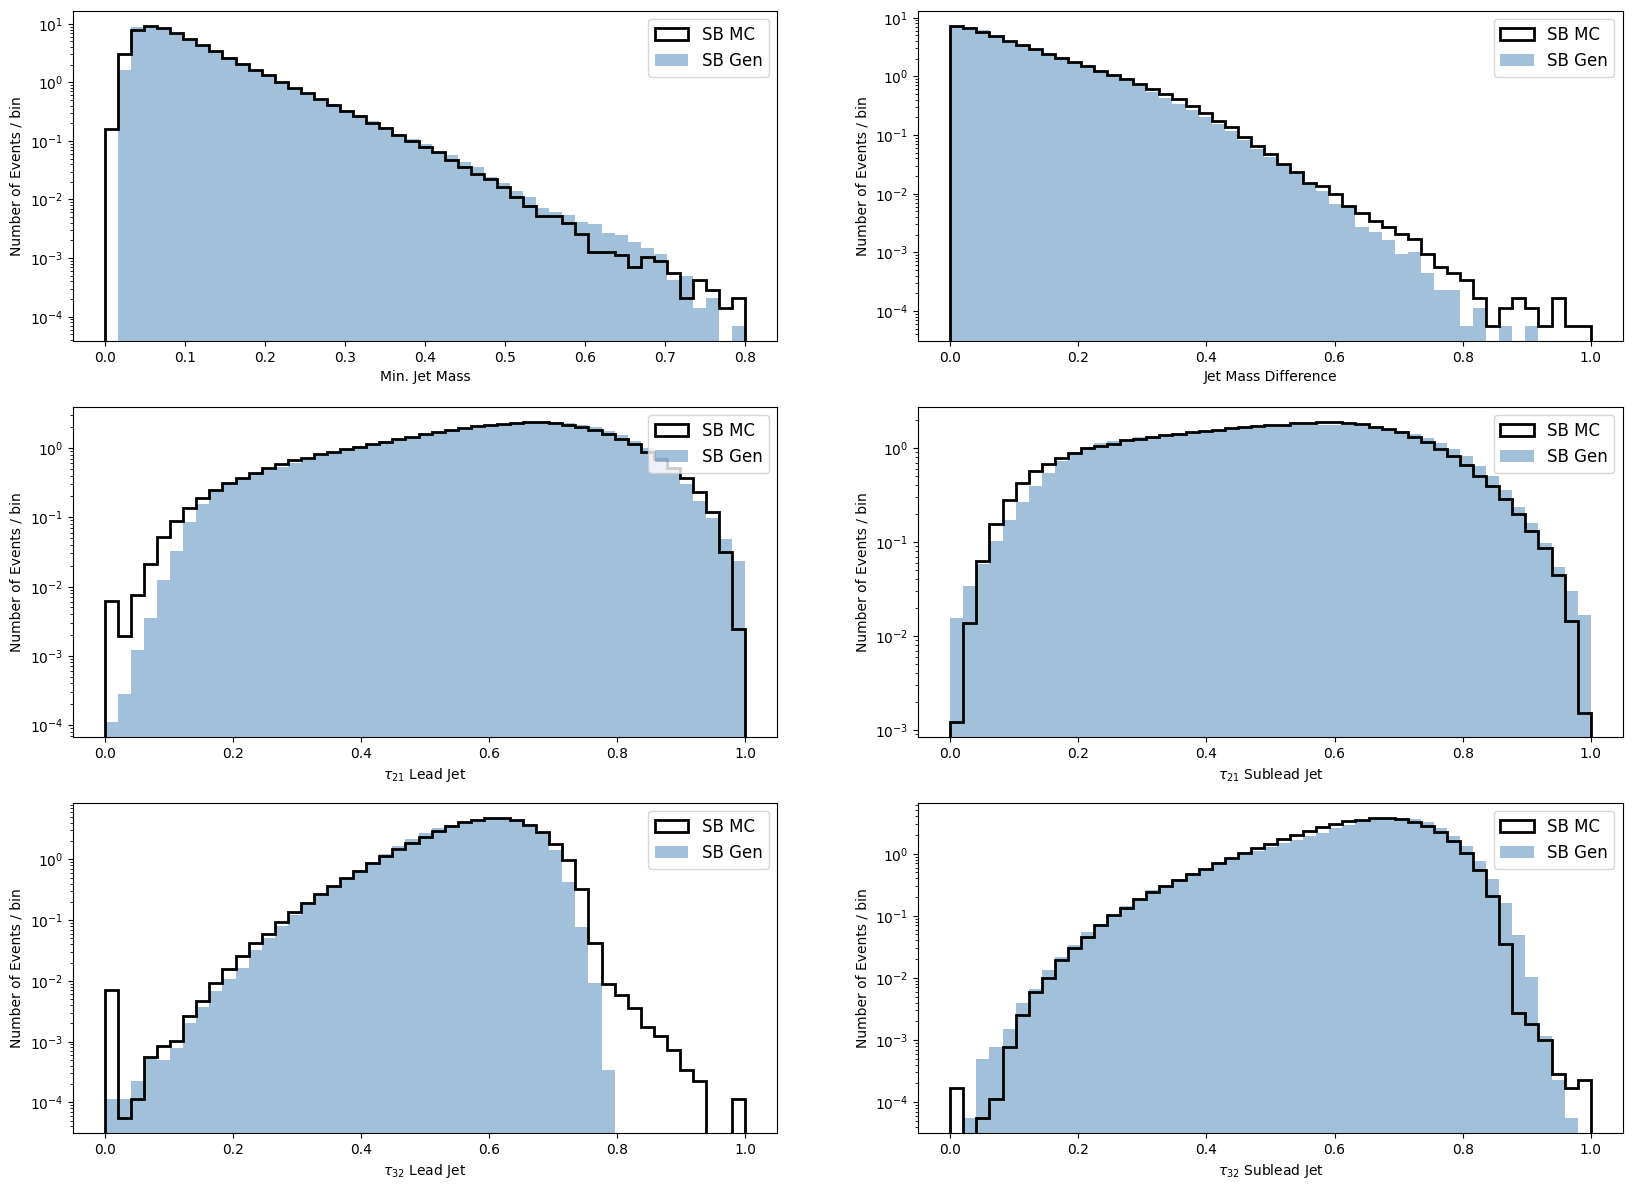

In [10]:
fake_vs_real([cfake_sb],[data],1)


In [11]:
from sklearn.neighbors import KernelDensity

innerdata_train = np.load("./data/preprocessed_data_6var/innerdata_train_6var.npy")
innerdata_test = np.load("./data/preprocessed_data_6var/innerdata_test_6var.npy")

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_test.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
print(x_SR.shape)
x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)
# x_SR = logit_norm(x_SR)


y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
y_SR, cond_data_SR_max, cond_data_SR_min = minmax_norm_cond_data(y_SR)
# y_SR = logit_norm(y_SR)
print(y_SR.shape)


KDE_bandwidth = 0.01
mjj_logit = quick_logit(y_SR)
y_sr_cond = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  mjj_logit.reshape(-1, 1)).sample(cond_data.shape[0]),
                                                   max(y_SR).item(),
                                                   min(y_SR).item())

(40000, 8)
(99605, 6)
(99605,)


In [12]:
plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}
def fake_vs_real2(gen_data,real_data,sig_data,doLog):
    plt.figure(figsize=(20,30))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,6):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],50)
        plt.subplot(6, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SB MC",density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="SR Gen",density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        for rd in sig_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="red", histtype='step', linewidth=2, label="SR MC", density=True)

        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        # ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        # plt.ylim(0,np.max([ymax_b,ymax_s])*1.5)

In [13]:
cfake_sr = generate_cond_data(0, cond_data.shape[0], y_sr_cond.reshape(y_sr_cond.shape[0],1)) #SR


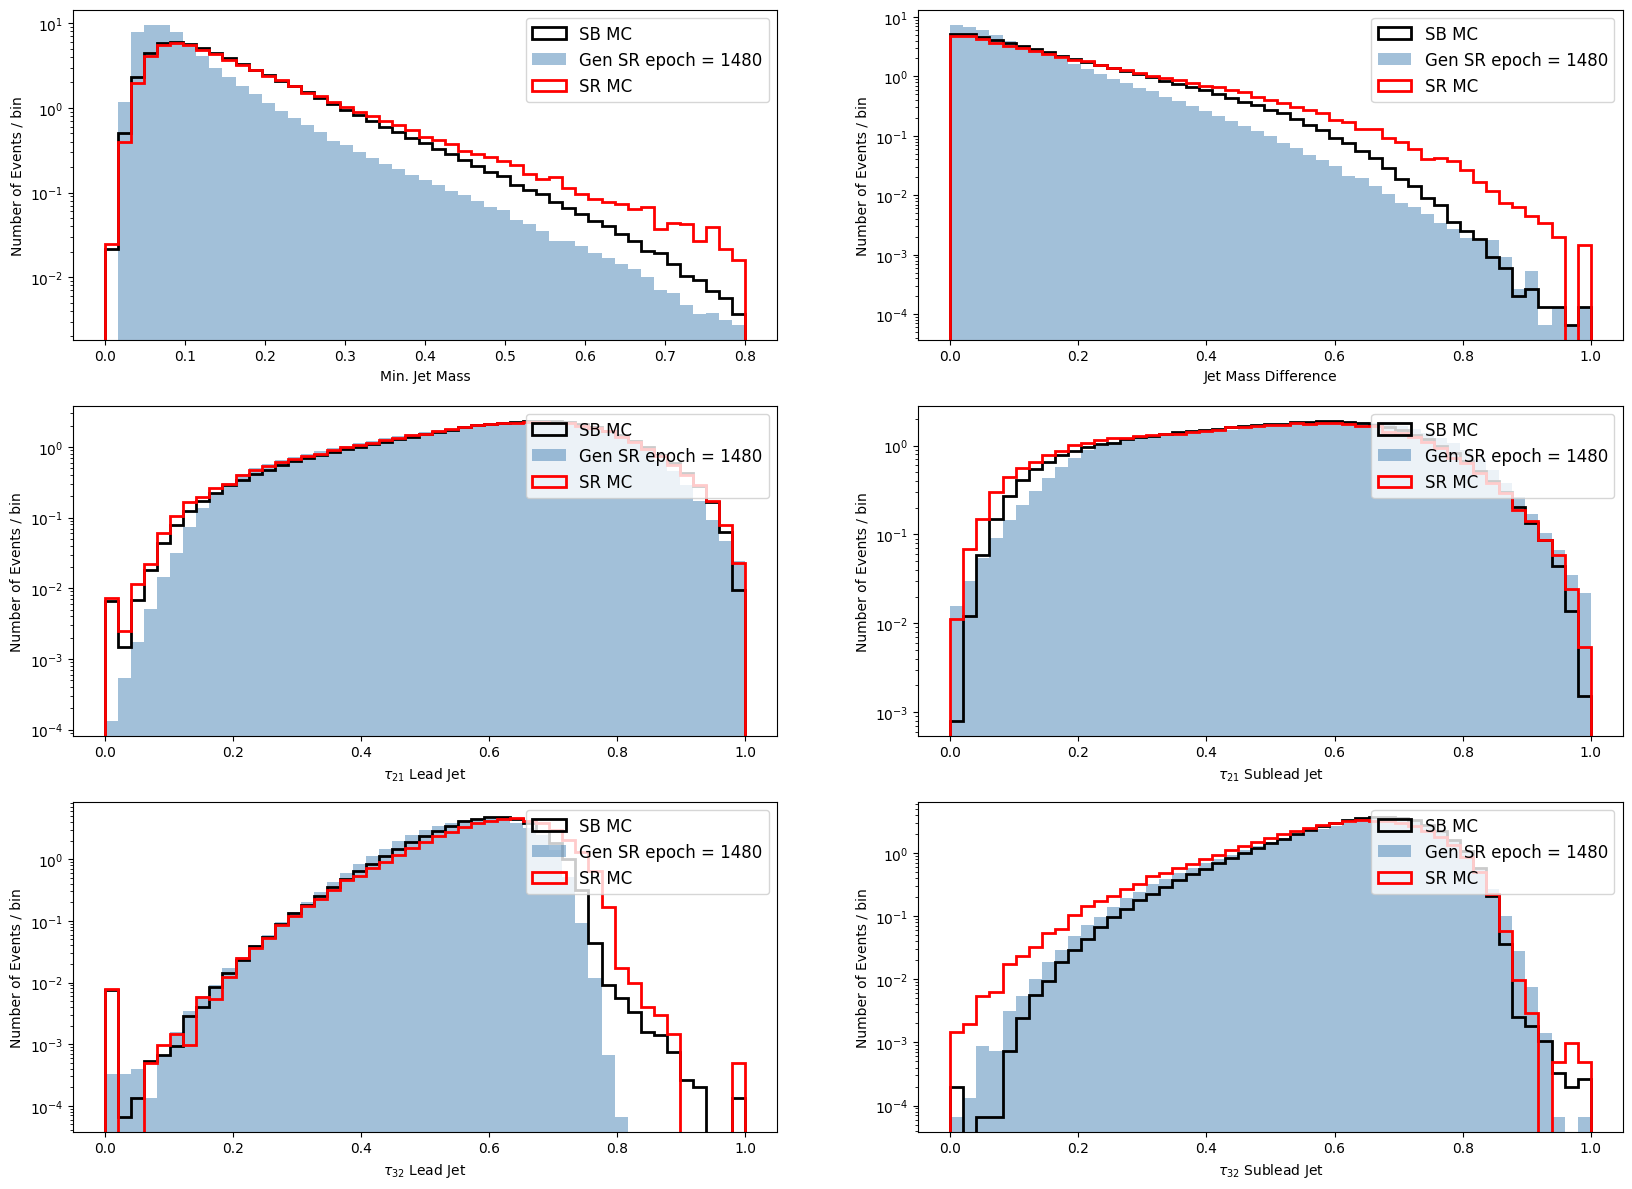

In [14]:
fake_vs_real2([cfake_sr],[data], [x_SR],1)
